# Описание задания

### Дано
Инженеры сервисной компании отчитываются по выполненным заявкам на ремонт АТМ в виде текстового сообщения. Заказчик работ (мониторинг Банка) обрабатывает отчеты и принимают решение о следующем действии по восстановлению АТМ.

На представленном датасете 91% заявок завершились "успешно", т.е. АТМ был в работоспособном состоянии. По оставшимся заявкам необходимо было прододожение работ.


### Постановка задачи
Необходимо разделить отчеты инженеров на 2 класса:
 - требующие ручной обработки - там, где требуется продолжение работ (ложный выезд, нарушены условия, необходимо продолжение работ и т.д.)
 - не требующие ручной обработки - заявка выполнена, работоспособность восстановлена. Дальнейшие действия бдут приняты без участия оператора мониторинга.
 
Отчеты инженеров представлены в файле wo.xlsx

# Импорты, настройки и чтение данных

In [1]:
import os

#IMPORTANT: PATH MIGHT BE DIFFERENT. SEE STEP 6
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#del os.environ["KERAS_BACKEND"]
#os.environ["RUNFILES_DIR"] = "/Users/alex/opt/anaconda3/lib/python3.7/site-packages/plaidml"
#os.environ["PLAIDML_NATIVE_PATH"] = "/Users/alex/opt/anaconda3/lib/libplaidml.dylib"

In [2]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pymystem3 import Mystem

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

#import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

#Options
np.random.seed(7)
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
warnings.filterwarnings("ignore")
%matplotlib inline  
random_state = 7

In [3]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")

with open("stopwords.txt") as f:
    stopwords = f.read().splitlines()

#Шпаргалка
grammems = {
    "A": "прилагательное",
    "ADV": "наречие",
    "ADVPRO": "местоименное наречие",
    "ANUM": "числительное-прилагательное",
    "APRO": "местоимение-прилагательное",
    "COM": "часть композита - сложного слова",
    "CONJ": "союз",
    "INTJ": "междометие",
    "NUM": "числительное",
    "PART": "частица",
    "PR": "предлог",
    "S": "существительное",
    "SPRO": "местоимение-существительное",
    "V": "глагол",
}

In [4]:
data = pd.read_excel("wo.xls", sheet_name="Лист1", usecols="B, E, I, K")
data.columns =["desc", "comment", "type", "class"]
display(data.head())

,desc,comment,type,class
0,CH Fatal;null;Требуется диагностика и ремонт у...,замена контроллера brm. установка прошивки 01....,SLM,1
1,Сейф не запускается. Доступ свободный.,замена кп. инициализация КП. тесты ок.,SLM,1
2,SerNo: 13-45170430 # ATM-438340\nРаботы КОРУС:...,"УЗЕЛS осмотр диагностика замена escrow модуля,...",SLM,1
3,Прошу провести профилактические работы на банк...,"произведена замена монитора, тесты ок.",Профилактика,1
4,Перед проведением профилактики прошу выключать...,Замена СБ. отключение журнального принтера и в...,SLM,1


# Предобработка текста

In [5]:
speech_parts = {"A", "ADV", "S", "V", "SPRO", "ADVPRO", "ANUM", "APRO", "NUM"}
stem = Mystem()

def sent_lemm(sentence):
    sentence_lemmed = []
    result = stem.analyze(sentence)
    for word in result:
        if "analysis" in word:
            if len(word["analysis"]):
                try:
                    word_lmd = word["analysis"][0]["lex"]
                    if len(speech_parts):
                        speech_part = re.split("[,=]+", word["analysis"][0]["gr"])
                        if speech_part[0] not in speech_parts:
                            continue
                    sentence_lemmed.append(word_lmd)
                except Exception:
                    print("lemm error: {}".format(word))
            else:
                sentence_lemmed.append(word["text"])
    return " ".join(sentence_lemmed)

X = data["comment"].apply(lambda x: REPLACE_NO_SPACE.sub("", x))
X = np.array([sent_lemm(x) for x in X])
print(X[:5])

['замена контроллер brm установка прошивка перестановка параметризация установка гейт установка картинка тест тестовый утилита открытие закрытие опердня'
 'замена кп инициализация кп тест ока'
 'УЗЕЛS осмотр диагностика замена escrow модуль тестирование тест ока открытие закрытие ода ока'
 'производить замена монитор тест ока'
 'замена СБ отключение журнальный принтер включение электронный журнал максимальный объем память']


# Датасет

In [6]:
y = data["class"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)

In [7]:
max_words = 1500
max_len = 30
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(sequences, maxlen=max_len)

sequences = tok.texts_to_sequences(X_test)
X_test_seq = sequence.pad_sequences(sequences, maxlen=max_len)

# Обучение модели

In [9]:
embedding_vecor_length = 64

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)

# create the model
model = Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length=max_len))
model.add(LSTM(64, dropout=0, return_sequences=True))
model.add(LSTM(30, dropout=0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
print(model.summary())
history = model.fit(X_train_seq, y_train, epochs=30, batch_size=8, validation_split=0.2, callbacks=[es])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 64)            96000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 140,455
Trainable params: 140,455
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
301/301 [==============================] - 5s 17ms/step - loss: 0.2814 - auc: 0.6564 - val_loss: 0.1625 - val_auc: 0.9586
Epoch 2/30
301/301 [==============================] - 5s 16ms/step - loss: 0.1163 - auc: 0.9643 - val_loss: 

# Проверка модели

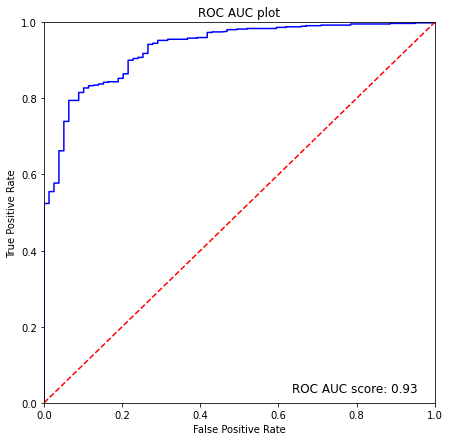

In [10]:
y_pred = model.predict(X_test_seq)

fpr, tpr, _ = roc_curve(y_test, y_pred)
rocauc_score = "ROC AUC score: {0:.2}".format(roc_auc_score(y_test, y_pred))

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, 'b-')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC plot")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.annotate(rocauc_score, xy=(0.65, 0.11), xycoords="figure fraction", fontsize=12)

plt.show()                                 

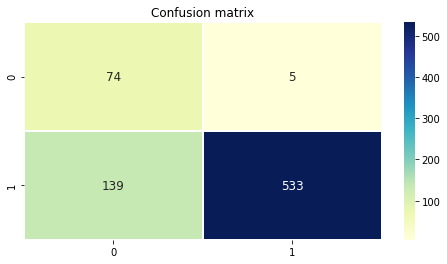

In [11]:
fpr_allowed = 0.08  #(for example)
idx = np.max(np.where(fpr<fpr_allowed))

cm = confusion_matrix(y_test, y_pred>_[idx])
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.heatmap(cm, linewidths=.5, cmap="YlGnBu", ax=ax, annot=True, fmt='d', annot_kws={"fontsize":12})
ax = ax.set_title("Confusion matrix")

# Заключение

Классификатор позволяет «понять» отчеты, где работа завершена успешно, и передать их на автоматическую обработку. Настройку порога срабатывания можно использовать для выбора приемлемого уровня ошибок при максимальном уровне автоматизации.

При пороге ошибок около 1% на автоматическую обработку можно передать около 70% отчетов.